In [7]:
import typing
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.sql import SparkSession, functions as f
from pyspark.sql.types import DoubleType, LongType, StructField, StructType
import xarray as xr

from dltools import SpkHits
from dltools.cov import cov3d_complicated
from dltools.cov.markup import compute

In [2]:
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)
spark = builder.getOrCreate()

In [3]:
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gte: 0.005},
            },
        },
        {
            $project: {
                tag: true,
                aq: true,
                gm2: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$and: [{$lte: ["$$item.flag", 14]},
                                      {$or: [{$ne: ["$$item.as_.C1p", undefined]},
                                             {$ne: ["$$item.as_.I1p", undefined]}]}]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("aq", LongType()),
            StructField("gm2", DoubleType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()

root
 |-- tag: long (nullable = true)
 |-- aq: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)



In [4]:
def ishit0(hit: pyspark.sql.Row) -> bool:
    return "C1p" in hit["as_"]


def ishit1(hit: pyspark.sql.Row) -> bool:
    return "I1p" in hit["as_"]


def ishit2(hit: pyspark.sql.Row) -> bool:
    return "I1p" in hit["as_"]


# n = 100
# n = 100000000
n = 1000000000  # It will take less than 2 hours
m = df.count()

combined = cov3d_complicated(
    df, ishit0, ishit1, ishit2,
    npart=12,
    opt1={
        "npart": 12,
        "fraction": 1,
    },
    opt2={
        # "npart": 60,
        "fraction": min(n ** (1/2) / m, 1),
    },
    opt3={
        # "npart": 300,
        "fraction": min(n ** (1/3) / m, 1),
    },
)

In [5]:
%%time
def hist(
        rows: typing.List[pyspark.sql.Row]
        ) -> typing.List[xr.Dataset]:
    filtered = [
        {
            "pz": (r["hit0"]["as_"]["C1p"]["pz"]
                   + r["hit1"]["as_"]["I1p"]["pz"]
                   + r["hit2"]["as_"]["I1p"]["pz"]),
            "px": (r["hit0"]["as_"]["C1p"]["px"]
                   + r["hit1"]["as_"]["I1p"]["px"]
                   + r["hit2"]["as_"]["I1p"]["px"]),
            "py": (r["hit0"]["as_"]["C1p"]["py"]
                   + r["hit1"]["as_"]["I1p"]["py"]
                   + r["hit2"]["as_"]["I1p"]["py"]),
            "ke": (r["hit0"]["as_"]["C1p"]["ke"]
                   + r["hit1"]["as_"]["I1p"]["ke"]
                   + r["hit2"]["as_"]["I1p"]["ke"]),
        }
        for r in rows
        if (-300 < (r["hit0"]["as_"]["C1p"]["px"]
                    + r["hit1"]["as_"]["I1p"]["px"]
                    + r["hit2"]["as_"]["I1p"]["px"]) < 300
            and -300 < (r["hit0"]["as_"]["C1p"]["py"]
                        + r["hit1"]["as_"]["I1p"]["py"]
                        + r["hit2"]["as_"]["I1p"]["py"]) < 300
            and -300 < (r["hit0"]["as_"]["C1p"]["pz"]
                        + r["hit1"]["as_"]["I1p"]["pz"]
                        + r["hit2"]["as_"]["I1p"]["pz"]) < 300
            and (r["hit2"]["t"] - r["hit1"]["t"]) < 120)
    ]
    edges_p = np.linspace(-300, 300, 121)  # bin size: 5
    edges_k = np.linspace(0, 100, 101)  # bin size: 1
    pz, *_ = np.histogram(
        [r["pz"] for r in filtered],
        bins=edges_p,
    )
    px, *_ = np.histogram(
        [r["px"] for r in filtered],
        bins=edges_p,
    )
    py, *_ = np.histogram(
        [r["py"] for r in filtered],
        bins=edges_p,
    )
    ke, *_ = np.histogram(
        [r["ke"] for r in filtered],
        bins=edges_k,
    )
    return [xr.Dataset(
        {"pz": ("edge_p", pz),
         "px": ("edge_p", px),
         "py": ("edge_p", py),
         "ker": ("edge_ker", ke)},
        coords={"edge_p": edges_p[:-1], "edge_ker": edges_k[:-1]}
    )]


d = combined(hist)

CPU times: user 1.62 s, sys: 88 ms, total: 1.7 s
Wall time: 29min 5s


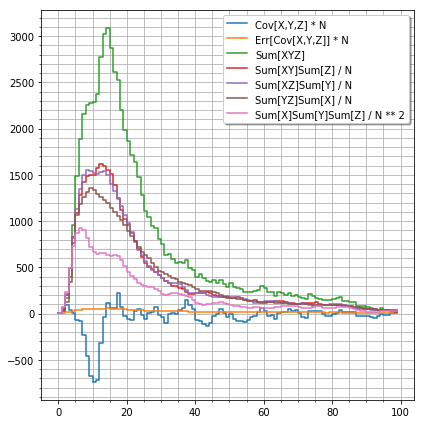

In [11]:
n = combined(hist)["N"]
x, y = "edge_ker", "ker"

plt.figure(figsize=(6, 6))
arr = combined(hist)["Cov[X,Y,Z]"]
plt.step(
    arr[x], arr[y] * n,
    label="Cov[X,Y,Z] * N",
    where="post",
)
arr = combined(hist)["Err[Cov[X,Y,Z]]"]
plt.step(
    arr[x], arr[y] * n,
    label="Err[Cov[X,Y,Z]] * N",
    where="post",
)
arr = compute(combined(hist)["Sum[XYZ]"])
plt.step(
    arr[x], arr[y],
    label="Sum[XYZ]",
    where="post",
)
arr = compute(combined(hist)["Sum[XY]Sum[Z]"])
plt.step(
    arr[x], arr[y] / n,
    label="Sum[XY]Sum[Z] / N",
    where="post",
)
arr = compute(combined(hist)["Sum[XZ]Sum[Y]"])
plt.step(
    arr[x], arr[y] / n,
    label="Sum[XZ]Sum[Y] / N",
    where="post",
)
arr = compute(combined(hist)["Sum[YZ]Sum[X]"])
plt.step(
    arr[x], arr[y] / n,
    label="Sum[YZ]Sum[X] / N",
    where="post",
)
arr = compute(combined(hist)["Sum[X]Sum[Y]Sum[Z]"])
plt.step(
    arr[x], arr[y] / n ** 2,
    label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
    where="post",
)
# plt.xlim(0, 100)
# plt.ylim(0, 20)
plt.minorticks_on()
plt.grid(True, which="both")
plt.legend(shadow=True)

plt.tight_layout()
plt.show()